# Hodgkin-Huxley equations
Simulating the equations and understanding them using numerical methods (computing V, m, n and h for every delta_t change in time)

In [40]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

#### Modeling movement of ions across channels
Here we have considered the concentration of ion x to be constant and modeled the chemical reaction as

$${x} \xrightarrow{\beta_x} {1}-{x} $$

$$ and $$

$${1}-{x} \xrightarrow{\alpha_x} {x} $$


$$ \frac{dx}{dt} = {\alpha_{x}} {(1-x)} - {\beta_{x}} ({x}) $$

solving the equation we get

$$ x = \frac{\alpha_{x} - {C}{e^{-(\alpha_{x}+\beta_{x}){t}}}} {\alpha_{x} + \beta_{x}} $$

from here we get 

$$ {x_\infty} = \frac{\alpha_{x}} {(\alpha_{x} + \beta_{x})} $$

$$ {\tau}_x = \frac{1} {\alpha_{x} + \beta_{x}} $$ 


In [210]:
# defining functions for getting rate constant and infinity values etc.
# functional relation for alpha and beta with voltage is taken from wikipedia

def alpha_n(volt):
    #alpha_n in function of voltage, potassium channel constant
    return 0.01 * (10 - volt) / (np.exp((10.0 - volt) / 10.0) - 1.0)

def beta_n(volt):
    #beta_n in function of voltage, potassium channel constant
    return 0.125 * np.exp(-volt / 80.0)

def alpha_m(volt):
    #alpha_m in function of voltage, sodium channel constant
    return 0.1 * (25.0 - volt) / (np.exp((25.0 - volt) / 10.0) - 1.0)

def beta_m(volt):
    #beta_m in function of voltage, sodium channel constant
    return 4.0 * np.exp(-volt / 18.0)

def alpha_h(volt):
    #alpha_h in function of voltage, sodium channel constant
    return 0.07 * np.exp(-volt / 20.0)

def beta_h(volt):
    #beta_h in function of voltage, sodium channel constant
    return 1.0 / (np.exp((30.0 - volt) / 10.0) + 1.0)

def x_tau(alpha_x, beta_x):
    #this method calculates the time constant tau for a certain ion channel.
    return 1.0 / (alpha_x + beta_x)

def x_inf(alpha_x, beta_x):
    #this method calculates the stationary constant x_inf for a certain ion channel.
    return alpha_x / (alpha_x + beta_x)

def injected_current(t):
    if 4.0 < t < 7.0:
        return 150.0
    elif 15.0 < t < 16.0:
        return 50.0
    elif 25.0 < t < 26.0:
        return 5.0
    return 0.0

In [211]:
T = 30 # total time
delta_t =0.001  # time interval
N = int(T/delta_t)+1 # total number of points
t = np.linspace(0,T,N)
v = np.zeros(N,dtype=np.float64)
m = np.zeros(N,dtype=np.float64)
n = np.zeros(N,dtype=np.float64)
h = np.zeros(N,dtype=np.float64)

v[0] = -70.0  # voltage in (mV)  
n[0] = 0.1
m[0] = 0.0
h[0] = 1.0

Cm = 1.0   # membrane capacitance (in µF/cm^2)
g_na_max = 120.0 # max sodium channel specific conductance (in mS/cm^2)
g_k_max = 36.0 # max potassium channel specific conductance (in mS/cm^2)
g_l = 0.3 # max leaky channel specific conductance (in mS/cm^2)

E_na = 50.0 # sodium resting potential (in mV)
E_k = -70.0 # potassium resting potential (in mV)
E_l =10.63 # leak potential

I_inj = np.zeros(N,dtype=np.float64)
I_ion = np.zeros(N,dtype=np.float64) 
I_na = np.zeros(N,dtype=np.float64)
I_k = np.zeros(N,dtype=np.float64)

I_ion[0]=0
I_na[0]=0
I_k[0]=0

tau_m = np.zeros(N,dtype=np.float64)
tau_n = np.zeros(N,dtype=np.float64)
tau_h = np.zeros(N,dtype=np.float64)
m_inf = np.zeros(N,dtype=np.float64)
n_inf = np.zeros(N,dtype=np.float64)
h_inf = np.zeros(N,dtype=np.float64)

#### Computing values of V, m, n and h with change in time

In [212]:
for i in range(1,N):
    I_inj[i] =injected_current(t[i])  # injected current at time t

    v[i] = v[i-1] +((delta_t*(I_inj[i] - I_ion[i-1]))/Cm)
    tau_m[i]=x_tau(alpha_m(v[i]),beta_m(v[i]))
    m_inf[i]=x_inf(alpha_m(v[i]),beta_m(v[i]))

    tau_n[i]=x_tau(alpha_n(v[i]),beta_n(v[i]))
    n_inf[i]=x_inf(alpha_n(v[i]),beta_n(v[i]))

    tau_h[i]=x_tau(alpha_h(v[i]),beta_h(v[i]))
    h_inf[i]=x_inf(alpha_h(v[i]),beta_h(v[i]))
    
    # Calculating m,n,h using alpha, beta only
    # m[i] = m[i-1] + delta_t*(alpha_m(v[i-1])*(1-m[i-1])-beta_m(v[i-1])*m[i-1])
    # n[i] = n[i-1] + delta_t*(alpha_n(v[i-1])*(1-n[i-1])-beta_n(v[i-1])*n[i-1])
    # h[i] = h[i-1] + delta_t*(alpha_h(v[i-1])*(1-h[i-1])-beta_h(v[i-1])*h[i-1])

    # Calculating m,n,h using infinity values and rate constant(tau)
    m[i] = m[i-1] + delta_t*((m_inf[i]-m[i-1])/tau_m[i])
    n[i] = n[i-1] + delta_t*((n_inf[i]-n[i-1])/tau_n[i])
    h[i] = h[i-1] + delta_t*((h_inf[i]-h[i-1])/tau_h[i])
    
    
    I_na[i] = np.power(m[i],3)*h[i]*g_na_max*(v[i]-E_na)
    I_k[i] =np.power(n[i],4)*g_k_max*(v[i]-E_k)
    I_ion[i] = I_na[i] + I_k[i] + g_l*(v[i]-E_l)

In [213]:
# approximating values of infinity and tau at time=0 to time=delta_t just to avoid confusion in graphs
m_inf[0] = m_inf[1]
n_inf[0] = n_inf[1]
h_inf[0] = h_inf[1]    

tau_m[0] = tau_m[1]
tau_n[0] = tau_n[1]
tau_h[0] = tau_h[1]    

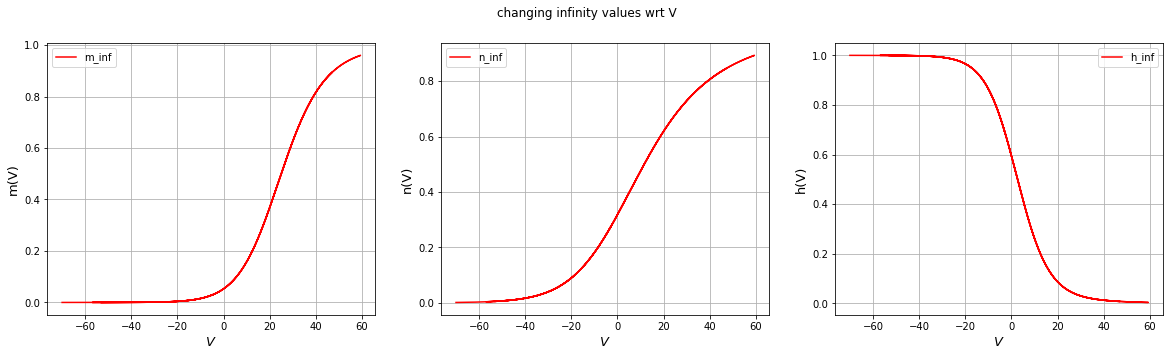

In [214]:
#ploting
f,ax = plt.subplots(1,3,figsize=(20,5))
f.suptitle('changing infinity values wrt V')
ax[0].plot(v,m_inf,'r',label ='m_inf')
ax[0].set_xlabel('$V$',fontsize=13)
ax[0].set_ylabel('m(V)',fontsize=13)
ax[0].grid(True)
ax[0].legend()
ax[1].plot(v,n_inf,'r',label ='n_inf')
ax[1].set_xlabel('$V$',fontsize=13)
ax[1].set_ylabel('n(V)',fontsize=13)
ax[1].grid(True)
ax[1].legend()
ax[2].plot(v,h_inf,'r',label ='h_inf')
ax[2].set_xlabel('$V$',fontsize=13)
ax[2].set_ylabel('h(V)',fontsize=13)
ax[2].grid(True)
ax[2].legend()

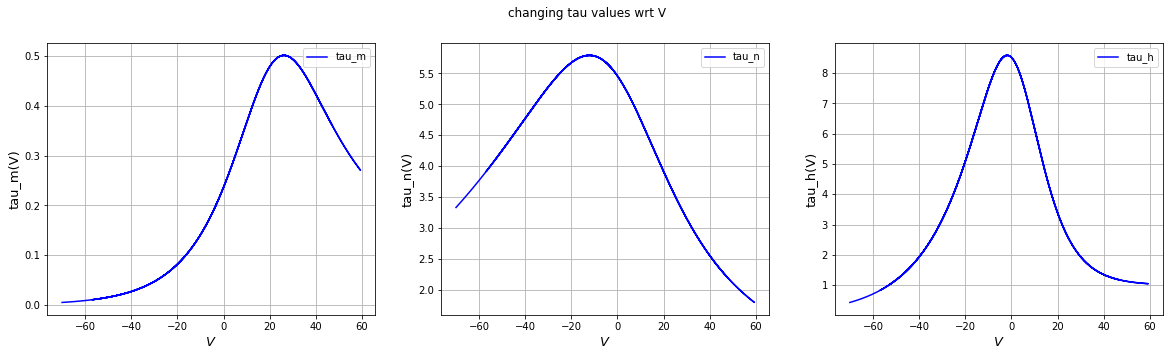

In [215]:
#ploting
f,ax = plt.subplots(1,3,figsize=(20,5))
f.suptitle('changing tau values wrt V')
ax[0].plot(v,tau_m,'b',label ='tau_m')
ax[0].set_xlabel('$V$',fontsize=13)
ax[0].set_ylabel('tau_m(V)',fontsize=13)
ax[0].grid(True)
ax[0].legend()
ax[1].plot(v,tau_n,'b',label='tau_n')
ax[1].set_xlabel('$V$',fontsize=13)
ax[1].set_ylabel('tau_n(V)',fontsize=13)
ax[1].grid(True)
ax[1].legend()
ax[2].plot(v,tau_h,'b',label ='tau_h')
ax[2].set_xlabel('$V$',fontsize=13)
ax[2].set_ylabel('tau_h(V)',fontsize=13)
ax[2].grid(True)
ax[2].legend()

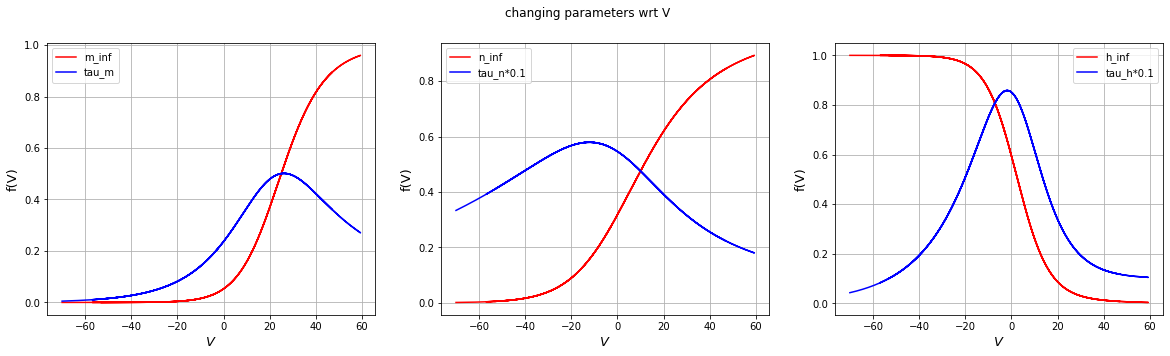

In [216]:
#ploting
f,ax = plt.subplots(1,3,figsize=(20,5))
f.suptitle('changing parameters wrt V')
ax[0].plot(v,m_inf,'r',label ='m_inf')
ax[0].plot(v,tau_m,'b',label ='tau_m')
ax[0].set_xlabel('$V$',fontsize=13)
ax[0].set_ylabel('f(V)',fontsize=13)
ax[0].grid(True)
ax[0].legend()
ax[1].plot(v,n_inf,'r',label ='n_inf')
ax[1].plot(v,tau_n*0.1,'b',label='tau_n*0.1')
ax[1].set_xlabel('$V$',fontsize=13)
ax[1].set_ylabel('f(V)',fontsize=13)
ax[1].grid(True)
ax[1].legend()
ax[2].plot(v,h_inf,'r',label ='h_inf')
ax[2].plot(v,tau_h*0.1,'b',label ='tau_h*0.1')
ax[2].set_xlabel('$V$',fontsize=13)
ax[2].set_ylabel('f(V)',fontsize=13)
ax[2].grid(True)
ax[2].legend()

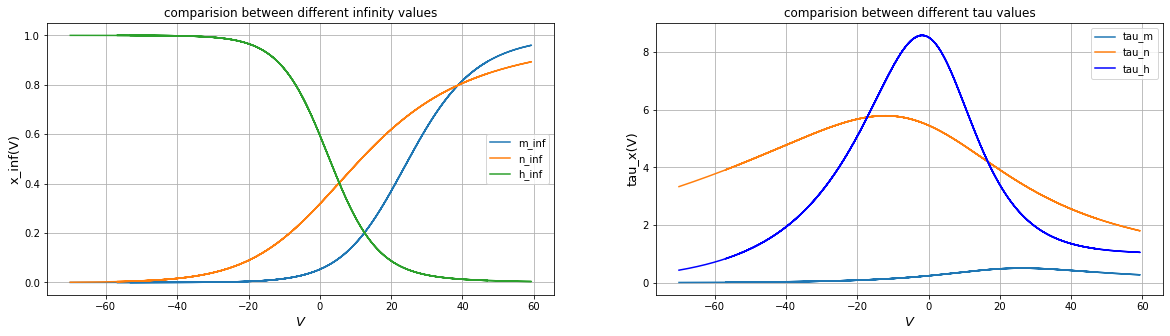

In [217]:
#ploting
f,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(v,m_inf,label ='m_inf')
ax[0].plot(v,n_inf,label ='n_inf')
ax[0].plot(v,h_inf,label ='h_inf')
ax[0].set_title('comparision between different infinity values')
ax[0].set_xlabel('$V$',fontsize=13)
ax[0].set_ylabel('x_inf(V)',fontsize=13)
ax[0].grid(True)
ax[0].legend()
ax[1].plot(v,tau_m,label ='tau_m')
ax[1].plot(v,tau_n,label='tau_n')
ax[1].plot(v,tau_h,'b',label ='tau_h')
ax[1].set_title('comparision between different tau values')
ax[1].set_xlabel('$V$',fontsize=13)
ax[1].set_ylabel('tau_x(V)',fontsize=13)
ax[1].grid(True)
ax[1].legend()

## Insights

m : activation gate for sodium channel

h : inactivation gate for sodium channel

n : activation gate for potassium channel
1. Since activation gate of potassium is not fully closed even at -70mV, there is always a bit of flow of K+ ions out of the cell, keeping the inside potential negative

2. Time constant for n and h are higher than m, resulting in delay fully opening of potassium activation gate and closing of sodium inactivation gate. So sodium activation gate opens quickly and we get a spike of 60mV, before the n goes to 1 and h goes to 0 again.

3. Higher time constant for n and h is the cause of delay in coming back to resting potential.


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


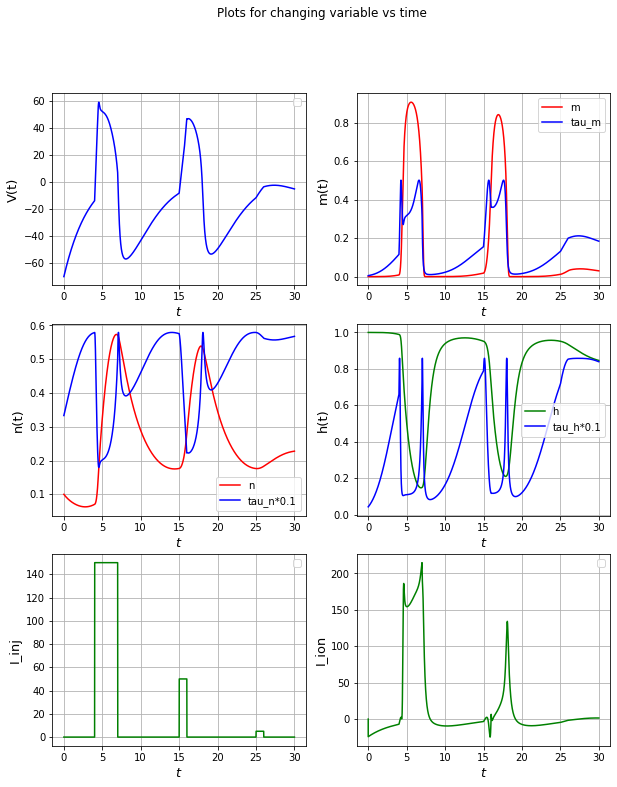

In [218]:
#ploting
f,ax = plt.subplots(3,2,figsize=(10,12))
f.suptitle('Plots for changing variable vs time')
ax[0,0].plot(t,v,'b')
ax[0,0].set_xlabel('$t$',fontsize=13)
ax[0,0].set_ylabel('V(t)',fontsize=13)
ax[0,0].grid(True)
ax[0,0].legend()
ax[0,1].plot(t,m,'r',label ='m')
ax[0,1].plot(t,tau_m,'b',label ='tau_m')
ax[0,1].set_xlabel('$t$',fontsize=13)
ax[0,1].set_ylabel('m(t)',fontsize=13)
ax[0,1].grid(True)
ax[0,1].legend()
ax[1,0].plot(t,n,'r',label ='n')
ax[1,0].plot(t,tau_n*0.1,'b',label ='tau_n*0.1')
ax[1,0].set_xlabel('$t$',fontsize=13)
ax[1,0].set_ylabel('n(t)',fontsize=13)
ax[1,0].grid(True)
ax[1,0].legend()
ax[1,1].plot(t,h,'g',label ='h')
ax[1,1].plot(t,tau_h*0.1,'b',label ='tau_h*0.1')
ax[1,1].set_xlabel('$t$',fontsize=13)
ax[1,1].set_ylabel('h(t)',fontsize=13)
ax[1,1].grid(True)
ax[1,1].legend()
ax[2,0].plot(t,I_inj,'g')
ax[2,0].set_xlabel('$t$',fontsize=13)
ax[2,0].set_ylabel('I_inj',fontsize=13)
ax[2,0].grid(True)
ax[2,0].legend()
ax[2,1].plot(t,I_ion,'g')
ax[2,1].set_xlabel('$t$',fontsize=13)
ax[2,1].set_ylabel('I_ion',fontsize=13)
ax[2,1].grid(True)
ax[2,1].legend()

## Insights

1. tau_m is much lower than tau_n and tau_h when we inject current resulting in quick depolarisation and spike. 

2. As soon as we get the action potential, tau_m decreases and tau_h and tau_n starts increasing resulting in repolarisation.

3. m increases and h decreases, only when we inject current otherwise they don't change, concluding that without the injected current there can't be any action potential.

4. n is always positive and increases during repolarisation, resulting in hyperpolarisation for short time.

5. It doesn't matter for how long we inject current the action potential cycle takes almost same time.

6. If injected current is too small we don't get any spike.

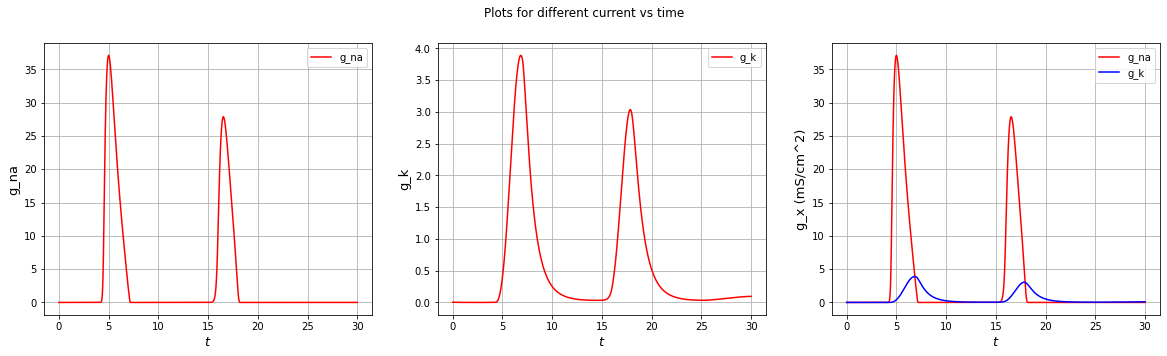

In [219]:
f,ax = plt.subplots(1,3,figsize=(20,5))
f.suptitle('Plots for different current vs time')
ax[0].plot(t,g_na_max*np.power(m,3)*h,'r',label ='g_na')
ax[0].set_xlabel('$t$',fontsize=13)
ax[0].set_ylabel('g_na',fontsize=13)
ax[0].grid(True)
ax[0].legend()
ax[1].plot(t,g_k_max*np.power(n,4),'r',label ='g_k')
ax[1].set_xlabel('$t$',fontsize=13)
ax[1].set_ylabel('g_k',fontsize=13)
ax[1].grid(True)
ax[1].legend()
ax[2].plot(t,g_na_max*np.power(m,3)*h,'r',label ='g_na')
ax[2].plot(t,g_k_max*np.power(n,4),'b',label ='g_k')
ax[2].set_xlabel('$t$',fontsize=13)
ax[2].set_ylabel('g_x (mS/cm^2)',fontsize=13)
ax[2].grid(True)
ax[2].legend()

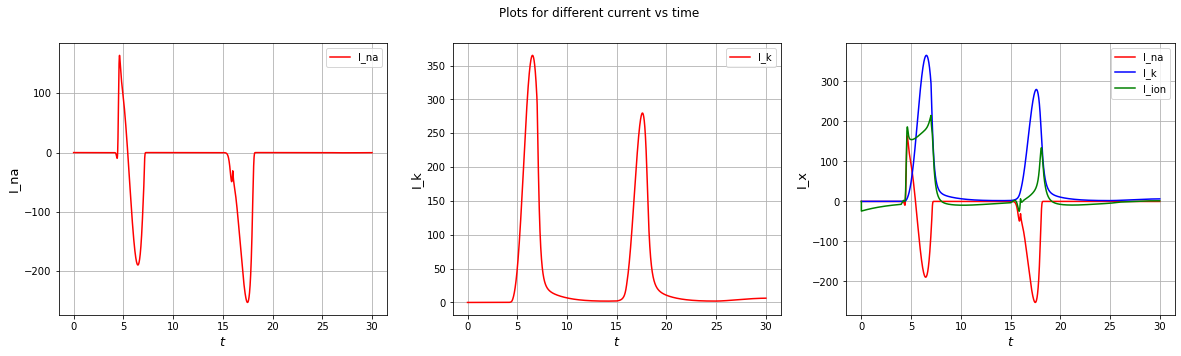

In [220]:
#ploting
f,ax = plt.subplots(1,3,figsize=(20,5))
f.suptitle('Plots for different current vs time')
ax[0].plot(t,I_na,'r',label ='I_na')
ax[0].set_xlabel('$t$',fontsize=13)
ax[0].set_ylabel('I_na',fontsize=13)
ax[0].grid(True)
ax[0].legend()
ax[1].plot(t,I_k,'r',label ='I_k')
ax[1].set_xlabel('$t$',fontsize=13)
ax[1].set_ylabel('I_k',fontsize=13)
ax[1].grid(True)
ax[1].legend()
ax[2].plot(t,I_na,'r',label ='I_na')
ax[2].plot(t,I_k,'b',label ='I_k')
ax[2].plot(t,I_ion,'g',label ='I_ion')
ax[2].set_xlabel('$t$',fontsize=13)
ax[2].set_ylabel('I_x',fontsize=13)
ax[2].grid(True)
ax[2].legend()

## Insights

1. Once we inject current sodium current is inward for just a milisecond and then goes positive. 

2. At high positive voltage, we get I_ion positive means there is high I_k and I_na also becoming positive.

3. When we don't inject any current I_ion remains positive since activation gate for potasium is always partialy open.

# Conclusion

Action potential arises due to opening of activation gate of sodium faster than closing of inactivation gates of sodium and opening of activation gate of potassium. High time constant for n and h results in delay in coming back to resting potential and provide time for spiking activity to happen. First sodium current is inward and soon it becomes postive when V = E_na, giving us overall I_ion to be positive for longer period.

Action potential cycle takes almost same time, doesn't depend on the time for which the current is injected.